# LSTM

To understand LSTM's we need to first understand, RNN's.

RNN's or Recurrent Neural Networks are networks with loops in them, allowing information to persist. A recurrent neural network can be thought of as multiple copies of the same network, each passing a message to a successor. Consider what happens if we unroll the loop:

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" alt="drawing" width="300"/>

This chain-like nature reveals that recurrent neural networks are intimately related to sequences and lists. They’re the natural architecture of neural network to use for such data.

However, traditional RNN's aren't capable of handling long term dependencies, therefore LSTM's were invented.

**Long Short Term Memory networks** – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies.
At a high-level LSTM works very much like an RNN cell. Here is the internal functioning of the LSTM network. The LSTM  consists of three parts, as shown in the image below and each part performs an individual function.
<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-16-13-41-03.png" alt="drawing" width="300"/>

LSTMs also help solve exploding and vanishing gradient problems. In simple terms, these problems are a result of repeated weight adjustments as a neural network trains. With repeated epochs, gradients become larger or smaller, and with each adjustment, it becomes easier for the network’s gradients to compound in either direction. This compounding either makes the gradients way too large or way too small. While exploding and vanishing gradients are huge downsides of using traditional RNN’s, LSTM architecture severely mitigates these issues.

After a prediction is made, it is fed back into the model to predict the next value in the sequence. With each prediction, some error is introduced into the model. To avoid exploding gradients, values are ‘squashed’ via (typically) sigmoid & tanh activation functions prior to gate entrance & output.


### Import Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import numpy
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error

### Import Data

In [2]:
!pip3 install pickle5
import pickle5 as pickle
with open('/content/drive/MyDrive/Timeseries_data.pkl', "rb") as fh:
  df = pickle.load(fh)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
df.sample(3)

,Date,Weighted_price
574,2014-07-30,214.287101
1363,2017-10-17,346.893130
493,2014-04-01,189.093465


Create new df with just the prices

In [4]:
data = df[['Weighted_price']]

In [5]:
data.head(3)

,Weighted_price
0,136.312065
1,137.683837
2,136.686676


### Data Pre-process

Since the LSTM is sensitive to integers we use a MinMax scaler to bring all prices within the range of (0,1)

In [6]:
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(np.array(data).reshape(-1,1))

In [7]:
data.shape

(2463, 1)

Date is split into train and test with a 70-30 split

In [8]:
training_size=int(len(data)*0.70)
test_size=len(data)-training_size
train_data,test_data=data[0:training_size,:],data[training_size:len(data),:1]

We reshape the data to create into a stacked array the program can parse

In [9]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [10]:
# reshape into X=t,t+1,t+2,t+3,..,t+n and Y=t+(n+1)
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:
print(X_train.shape), print(y_train.shape)

(1693, 30)
(1693,)


(None, None)

In [12]:
print(X_test.shape), print(ytest.shape)

(708, 30)
(708,)


(None, None)

In [13]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### Define and Train Model

We define the LSTM Model with:

1. 50 units i.e. output dimensionality
2. Activation function - Tanh
3. return the just the output sequence and not the full sequence
4. loss function is MSE
5. Optimizer is ADAM 

3 LSTM layers are used with 1 Dense layer. The dense layer is a neural network layer that is connected deeply, which means each neuron in the dense layer receives input from all neurons of its previous layer. In the background, the dense layer performs a matrix-vector multiplication. The values used in the matrix are actually parameters that can be trained and updated with the help of backpropagation.

In [14]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


* The batch size is a hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated.
* The number of epochs is a hyperparameter of gradient descent that controls the number of complete passes through the training dataset.
* Verbose = 1 shows us each epoch running in a status bar

In [16]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=150,batch_size=64,verbose=1)

Epoch 1/150
27/27 [==============================] - 7s 52ms/step - loss: 0.0322 - val_loss: 0.0059
Epoch 2/150
27/27 [==============================] - 0s 12ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 3/150
27/27 [==============================] - 0s 11ms/step - loss: 5.9031e-04 - val_loss: 0.0023
Epoch 4/150
27/27 [==============================] - 0s 11ms/step - loss: 5.1389e-04 - val_loss: 0.0021
Epoch 5/150
27/27 [==============================] - 0s 12ms/step - loss: 5.1284e-04 - val_loss: 0.0023
Epoch 6/150
27/27 [==============================] - 0s 12ms/step - loss: 5.0628e-04 - val_loss: 0.0022
Epoch 7/150
27/27 [==============================] - 0s 11ms/step - loss: 5.2586e-04 - val_loss: 0.0021
Epoch 8/150
27/27 [==============================] - 0s 12ms/step - loss: 4.9760e-04 - val_loss: 0.0021
Epoch 9/150
27/27 [==============================] - 0s 11ms/step - loss: 5.1789e-04 - val_loss: 0.0021
Epoch 10/150
27/27 [==============================] - 0s 11ms/step - los

### Predictions

In [17]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [18]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [19]:
math.sqrt(mean_squared_error(y_train,train_predict))

259.4932058422618

In [20]:
math.sqrt(mean_squared_error(ytest,test_predict))

354.65493796410794

In [49]:
predict_test_lstm = pd.DataFrame()
predict_test_lstm['Test Values'] = list(test_predict)

In [50]:
predict_train_lstm = pd.DataFrame()
predict_train_lstm['Train Values'] = list(train_predict)

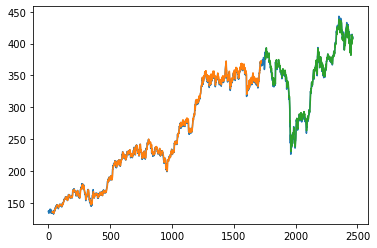

In [21]:
### Plotting 
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = numpy.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(data)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Here we can see that the predicted values are almost overlapping the actual values.

### Forecast

Since we want to forecast the next 30 days, we use the test data on the model and forecast for the next 30 days

In [22]:
test_len = len(test_data)
x_input=test_data[(test_len-time_step):].reshape(1,-1)
x_input.shape

(1, 30)

In [23]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [24]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=time_step
i=0
while(i<30):
    
    if(len(temp_input)>time_step):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.89353144]
31
1 day input [0.90983343 0.90586719 0.90912763 0.89674648 0.8798512  0.88066444
 0.81961878 0.85157109 0.85895089 0.83644057 0.83827271 0.82912112
 0.80354631 0.82594469 0.84227628 0.86130678 0.87079358 0.88257709
 0.86520937 0.88716728 0.90521832 0.88750549 0.90872361 0.90553095
 0.89631087 0.88580557 0.89073048 0.88938393 0.89533071 0.89353144]
1 day output [[0.88982975]]
2 day input [0.90586719 0.90912763 0.89674648 0.8798512  0.88066444 0.81961878
 0.85157109 0.85895089 0.83644057 0.83827271 0.82912112 0.80354631
 0.82594469 0.84227628 0.86130678 0.87079358 0.88257709 0.86520937
 0.88716728 0.90521832 0.88750549 0.90872361 0.90553095 0.89631087
 0.88580557 0.89073048 0.88938393 0.89533071 0.89353144 0.88982975]
2 day output [[0.8861786]]
3 day input [0.90912763 0.89674648 0.8798512  0.88066444 0.81961878 0.85157109
 0.85895089 0.83644057 0.83827271 0.82912112 0.80354631 0.82594469
 0.84227628 0.86130678 0.87079358 0.88257709 0.86520937 0.88716728
 0.90521832 0.887505

In [25]:
day_new=np.arange(1,31)
day_pred=np.arange(31,61)

In [26]:
data_len = len(data)

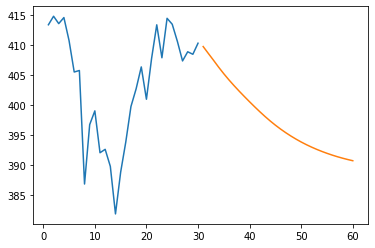

In [27]:
plt.plot(day_new,scaler.inverse_transform(data[(data_len-time_step):]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

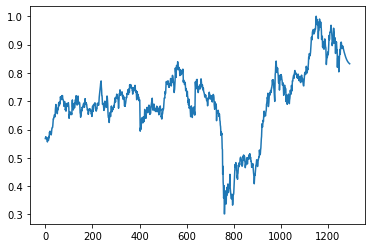

In [28]:
df3=data.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [31]:
len(df3)

2493

In [35]:
forecast = pd.DataFrame()

In [43]:
forecast['Prices'] = list(scaler.inverse_transform(df3))

In [51]:
forecast_lstm = forecast.copy()

### Export Predicted and Forecasted Data

In [53]:
forecast_lstm.to_csv('/content/drive/MyDrive/lstm_forecast.csv')
predict_test_lstm.to_csv('/content/drive/MyDrive/lstm_predicted_test.csv')
predict_train_lstm.to_csv('/content/drive/MyDrive/lstm_predicted_train.csv')